In [1]:
%pip install transformers[torch] pandas scikit-learn matplotlib seaborn accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 46.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 32.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 54.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
%pip install --upgrade transformers accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.1/367.1 kB 5.2 MB/s eta 0:00:00
  Attempting uninstall: accelerate
    Found existing installation: accelerate 1.8.1
    Uninstalling accelerate-1.8.1:
      Successfully uninstalled accelerate-1.8.1


In [3]:
%pip install --upgrade pip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 16.5 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


In [ ]:
# Step 0: Install required packages
# Using -q for a quieter installation
%pip install -q pandas numpy scikit-learn transformers[torch] datasets matplotlib seaborn

# Step 1: Import necessary libraries
import pandas as pd
import numpy as np
import json
import os
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# ==============================================================================
# Step 2: Data Loading Function
# ==============================================================================

def load_data(file_path):
    """
    Load data from a JSON file. This function is robust and can handle both
    a simple JSON array of objects and a dictionary containing the list of objects.
    """
    print(f"Attempting to load data from: {file_path}")
    if not os.path.exists(file_path):
        print(f"Error: File not found at '{file_path}'")
        print("Creating a dummy 'resources/training_data.json' for demonstration.")
        os.makedirs('resources', exist_ok=True)
        dummy_data = {
            "training_data": [
                {"text": "The first claim is valid.", "type": "Claim"},
                {"text": "The second claim is also valid.", "type": "Claim"},
                {"text": "The first premise is a fact.", "type": "Premise"},
                {"text": "The second premise is an opinion.", "type": "Premise"},
                {"text": "This sentence is just background info.", "type": "Other"} # This class has only 1 sample
            ]
        }
        with open(file_path, 'w') as f:
            json.dump(dummy_data, f, indent=2)

    try:
        with open(file_path, 'r', encoding='utf-8') as f: data = json.load(f)
        if isinstance(data, dict):
            for key in ['training_data', 'data', 'records']:
                if key in data and isinstance(data[key], list): records = data[key]; break
            else: raise ValueError("JSON is a dict but no list key was found.")
        elif isinstance(data, list): records = data
        else: raise TypeError("Unsupported JSON format.")

        df = pd.DataFrame(records)
        if 'type' in df.columns: df.rename(columns={'type': 'label'}, inplace=True)
        if not all(col in df.columns for col in ['text', 'label']): raise ValueError("Records must contain 'text' and 'type'/'label' keys.")
        print("Data loaded and parsed successfully!")
        return df
    except Exception as e:
        print(f"Error loading or processing data: {str(e)}")
        return None

# ==============================================================================
# Step 3: Main Execution Block
# ==============================================================================

file_path = 'resources/training_data.json'
df = load_data(file_path)

if df is not None and not df.empty:
    print("\n--- Data Overview ---")
    print("Original label distribution:")
    print(df['label'].value_counts())

    # *** MAJOR FIX FOR STRATIFICATION ERROR ***
    # Check for classes with only one member and duplicate them.
    label_counts = df['label'].value_counts()
    minority_classes = label_counts[label_counts < 2].index.tolist()

    if minority_classes:
        print(f"\nWarning: The following classes have only 1 sample: {minority_classes}")
        print("Duplicating these samples to allow for stratified splitting.")

        records_to_add = []
        for cls in minority_classes:
            records_to_add.append(df[df['label'] == cls].iloc[0])

        df = pd.concat([df] + [pd.DataFrame([rec]) for rec in records_to_add], ignore_index=True)

        print("\nNew label distribution after duplication:")
        print(df['label'].value_counts())
    # *** END OF FIX ***

    # --- Data Preparation ---
    print("\n--- Preparing Data for Model ---")
    labels = sorted(df['label'].unique().tolist())
    label_to_id = {label: i for i, label in enumerate(labels)}
    id_to_label = {i: label for label, i in label_to_id.items()}
    df['label_id'] = df['label'].map(label_to_id)

    # This will now work without errors
    train_texts, test_texts, train_labels, test_labels = train_test_split(
        df['text'].tolist(), df['label_id'].tolist(), test_size=0.5, random_state=42, stratify=df['label_id'] # Changed test_size to 0.5
    )

    # model_name = "nlpaueb/legal-bert-base-uncased"
    model_name = "nlpaueb/legal-bert-base-uncased"
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
    test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=128)

    class LegalDataset(torch.utils.data.Dataset):
        def __init__(self, encodings, labels):
            self.encodings = encodings; self.labels = labels
        def __getitem__(self, idx):
            item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}; item['labels'] = torch.tensor(self.labels[idx]); return item
        def __len__(self): return len(self.labels)

    train_dataset = LegalDataset(train_encodings, train_labels)
    test_dataset = LegalDataset(test_encodings, test_labels)

    # --- Model Training ---
    print("\n--- Initializing Model and Trainer ---")
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(id_to_label), id2label=id_to_label, label2id=label_to_id)

    def compute_metrics(pred):
        labels = pred.label_ids; preds = pred.predictions.argmax(-1)
        precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted', zero_division=0)
        acc = accuracy_score(labels, preds)
        return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}

    training_args = TrainingArguments(
        output_dir='./results', num_train_epochs=3, per_device_train_batch_size=8,
        per_device_eval_batch_size=8, warmup_steps=100, weight_decay=0.01,
        logging_dir='./logs', logging_steps=10, eval_strategy="epoch", # Changed evaluation_strategy to eval_strategy
        save_strategy="epoch", save_steps=1000, load_best_model_at_end=True, metric_for_best_model="f1", # Removed save_strategy
        report_to="none" # Added to disable reporting to external services like wandb
    )

    trainer = Trainer(model=model, args=training_args, train_dataset=train_dataset, eval_dataset=test_dataset, compute_metrics=compute_metrics)

    print("\n--- Starting Model Training ---")
    trainer.train()
    print("\n--- Training Finished ---")

    print("\n--- Final Evaluation on Test Set ---")
    eval_results = trainer.evaluate()
    print(eval_results)

    # --- Save Model and Run Inference ---
    output_dir = "./legal_argument_model"
    trainer.save_model(output_dir)
    tokenizer.save_pretrained(output_dir)
    print(f"\nModel and tokenizer saved to {output_dir}")

    def predict(text, model_path, tokenizer_path):
        model = AutoModelForSequenceClassification.from_pretrained(model_path); tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
        with torch.no_grad(): outputs = model(**inputs)
        predicted_class_id = torch.argmax(outputs.logits, dim=1).item()
        return model.config.id2label[predicted_class_id]

    example_text = "The defendant's actions were clearly in violation of the contract terms."
    predicted_label = predict(example_text, output_dir, output_dir)
    print(f"\n--- Example Prediction ---")
    print(f"Text: '{example_text}'")
    print(f"Predicted Label: {predicted_label}")

else:
    print("\nExecution halted because data could not be loaded or is empty.")

Note: you may need to restart the kernel to use updated packages.


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Attempting to load data from: resources/training_data.json
Data loaded and parsed successfully!

--- Data Overview ---
Original label distribution:
label
Premise              117
Claim                 79
Non-Argumentative     45
Name: count, dtype: int64

--- Preparing Data for Model ---

--- Initializing Model and Trainer ---


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Starting Model Training ---


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.095900,1.058322,0.487603,0.359055,0.551491,0.487603
2,1.069400,1.026287,0.487603,0.321437,0.239738,0.487603
3,1.048500,1.009153,0.495868,0.341942,0.328530,0.495868


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



--- Training Finished ---

--- Final Evaluation on Test Set ---


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 1.0583217144012451, 'eval_accuracy': 0.48760330578512395, 'eval_f1': 0.3590546324633826, 'eval_precision': 0.5514911965504851, 'eval_recall': 0.48760330578512395, 'eval_runtime': 18.2394, 'eval_samples_per_second': 6.634, 'eval_steps_per_second': 0.877, 'epoch': 3.0}

Model and tokenizer saved to ./legal_argument_model

--- Example Prediction ---
Text: 'The defendant's actions were clearly in violation of the contract terms.'
Predicted Label: Premise


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


<Figure size 1000x800 with 0 Axes>

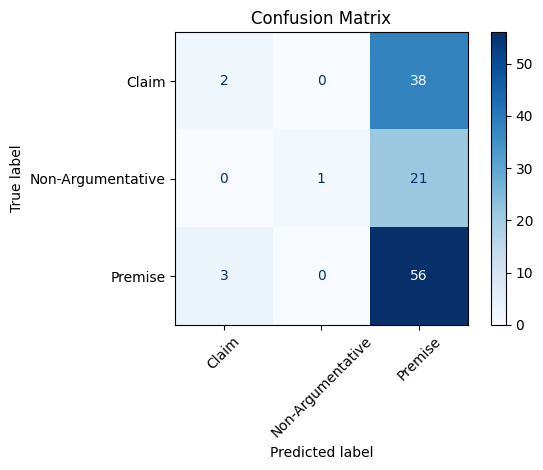


Classification Report:
                   precision    recall  f1-score   support

            Claim       0.40      0.05      0.09        40
Non-Argumentative       1.00      0.05      0.09        22
          Premise       0.49      0.95      0.64        59

         accuracy                           0.49       121
        macro avg       0.63      0.35      0.27       121
     weighted avg       0.55      0.49      0.36       121



In [3]:
# First, let's make sure we have the test set prepared
if 'test_texts' not in locals() and 'test_labels' not in locals():
    # If we don't have a separate test set, we'll use the validation set
    test_texts = val_texts
    test_labels = val_labels
    print("Using validation set for testing since no separate test set was found")

# Tokenize the test set
tokenized_test = tokenizer(
    test_texts,
    padding=True,
    truncation=True,
    max_length=128,
    return_tensors="pt"
)

# Convert to PyTorch dataset
class LegalDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Create test dataset
test_dataset = LegalDataset(tokenized_test, test_labels)

# Now get predictions
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=1)

# Get true labels
true_labels = np.array(test_labels)

# Create confusion matrix
cm = confusion_matrix(true_labels, preds)

# Get class names (make sure these match your label2id mapping)
class_names = [trainer.model.config.id2label[i] for i in range(len(trainer.model.config.id2label))]

# Plot confusion matrix
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print classification report for more detailed metrics
from sklearn.metrics import classification_report
print("\nClassification Report:")
print(classification_report(true_labels, preds, target_names=class_names))

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
